# BPR

In [1]:
%reload_ext blackcellmagic
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler
%load_ext Cython

In [2]:
import logging

logging.basicConfig(
    format="[%(asctime)s]: %(message)s (%(filename)s:%(lineno)d)",
    level=logging.INFO,
    datefmt="%H.%M.%S",
)

In [3]:
from bpr import plotting
from dataclasses import dataclass
from enum import Enum
from functools import partial
from matplotlib import cm
from multiprocessing import cpu_count
from pprint import pprint
from pprint import pprint
from typing import Dict
from typing import List, Union, TypeVar, Any, Optional, List
import bpr
import glob
import seaborn as sns
import itertools
import json
import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import re
import yaml

## Train using CLI tool

In [14]:
!ls ../data/outputs | wc -l

     222


In [15]:
output_dir = pathlib.Path("../data/outputs")

In [16]:
def parse(fname: pathlib.Path):
    try:
        dataset, sampler, method, rand_option, others = fname.name.split("-")
    except ValueError:
        print(fname.name)
        dataset, sampler, others = fname.name.split("-")
        method = 'default'
        rand_option = 'default'

    def fname_to_dict() -> Dict:
        parts = dict()
        prefixes = {
            "bs": (int, "batch_size"),
            "ep": (int, "epochs"),
            "li": (float, "lr_item"),
            "lu": (float, "lr_user"),
            "nf": (int, "n_factors"),
            "rg": (float, "reg"),
            "rv": (bool, "reverse"),
            "wu": (int, "warm_up"),
            "se0": (int, "se_0"),
            "send": (int, "se_end"),
            "ws": (int, "window_size"),
        }
        for prefix, class_and_alias in prefixes.items():
            if prefix not in others:
                continue
            cls, alias = class_and_alias

            pattern = r"{}(\d+).*"
            if prefix == "rv":
                pattern = r"{}(\w).*"

            parts[alias] = re.findall(pattern.format(prefix), others)[0]

            if cls is float and parts[alias].startswith("0"):
                z = list(parts[alias])
                z.insert(1, ".")
                parts[alias] = "".join(z)
            parts[alias] = cls(parts[alias])

        return parts
    sampler_lookups = {'rec': 'RecencyBias', 'ran': 'RandomSampler', 'onl': 'OnlineSampler'}
    parsed = fname_to_dict()
    parsed['dataset'] = dataset.replace("mk", "ml-100k")
    parsed['method'] = method.replace("mn", 'mean')
    parsed['rand_option'] = rand_option.replace("ca", "cached")
    parsed['sampler'] = sampler_lookups.get(sampler, sampler)
    df = pd.read_feather(fname.as_posix())
    df['experiment'] = fname.name.split(".")[0]
    return df, parsed


def _fn():
    for idx, fname in enumerate(output_dir.resolve().glob("*.feather")):
        df, params = parse(fname)
        df['label'] = idx
        for k, v in params.items():
            df[k] = v
        yield df
        
df_all = pd.concat(_fn())

display(df_all.head())

mk-ran-bs32ep200li005lu005nf10rg001.feather


,epoch,HR@10,loss_avg,loss_med,experiment,label,batch_size,epochs,lr_item,lr_user,...,reverse,warm_up,se_0,se_end,dataset,method,rand_option,sampler,window_size,train_loss
0,0,0.686108,0.170838,0.1,mk-onl-mn-ca-bs32ep200li005lu005nf10rg001rvTwu...,0,32,200,0.05,0.05,...,True,150.0,1000.0,1.0,ml-100k,mean,cached,OnlineSampler,NaN,NaN
1,1,0.668081,0.175822,0.1,mk-onl-mn-ca-bs32ep200li005lu005nf10rg001rvTwu...,0,32,200,0.05,0.05,...,True,150.0,1000.0,1.0,ml-100k,mean,cached,OnlineSampler,NaN,NaN
2,2,0.679745,0.160657,0.1,mk-onl-mn-ca-bs32ep200li005lu005nf10rg001rvTwu...,0,32,200,0.05,0.05,...,True,150.0,1000.0,1.0,ml-100k,mean,cached,OnlineSampler,NaN,NaN
3,3,0.723224,0.177200,0.1,mk-onl-mn-ca-bs32ep200li005lu005nf10rg001rvTwu...,0,32,200,0.05,0.05,...,True,150.0,1000.0,1.0,ml-100k,mean,cached,OnlineSampler,NaN,NaN
4,4,0.696713,0.165111,0.1,mk-onl-mn-ca-bs32ep200li005lu005nf10rg001rvTwu...,0,32,200,0.05,0.05,...,True,150.0,1000.0,1.0,ml-100k,mean,cached,OnlineSampler,NaN,NaN


In [22]:
experiments = sorted(
    [
        x
        for x in df_all["experiment"].unique()
        if x.startswith("mk-rec") or x.startswith("mk-ran")
    ]
)
pprint(experiments[:5])

['mk-ran-bs32ep200li005lu005nf10rg001',
 'mk-rec-gd-ca-bs32ep200li005lu005nf10rg001rvTwu100se01000send100ws5',
 'mk-rec-gd-ca-bs32ep200li005lu005nf10rg001rvTwu100se01000send1ws5',
 'mk-rec-gd-ca-bs32ep200li005lu005nf10rg001rvTwu100se0100send1000ws5',
 'mk-rec-gd-ca-bs32ep200li005lu005nf10rg001rvTwu100se0100send1ws5']


In [18]:
df_all.experiment.nunique()

222

In [25]:
metric = "HR@10"


def get_best_perfs(df_all: pd.DataFrame, exclude: Optional[List[str]]=None) -> pd.DataFrame:
    def _g():
        for experiment, df in df_all.groupby("experiment"):
            if exclude and any(s in experiment for s in exclude):
                continue
            best = df[metric].max()
            best_idx = df[df[metric] == best].index[0]
#             best_values[experiment] = BestPerf(
#                 experiment=experiment, value=best, epoch=best_idx
#             )
            yield {"experiment": experiment, metric: best, "epoch": best_idx}
    return pd.DataFrame(_g()).set_index('experiment')

df_best = get_best_perfs(df_all, exclude=['-sd-', '-mn-'])
df_best.shape

(75, 2)

In [27]:
from matplotlib.markers import MarkerStyle

In [28]:
MARKERS = list(MarkerStyle.markers.keys())

In [29]:
df_best.shape

(75, 2)

In [59]:
DEFAULT_REPLACE = {
    k: ""
    for k in (
        "mk-",
        "bs32",
        "ep200",
        "li005",
        "lu005",
        "nf10",
        "rg001",
        "rvT",
    )
}
def plot_scatter(
    df_best,
    baseline="mk-ran-bs32ep200li005lu005nf10rg001",
    eps_hr=0.01,
    title=None,
    criteria: Optional[List[str]] = None,
    replacements: Optional[Dict[str, str]] = None,
    figsize=(16, 10)
):
    baseline_row = df_best.loc[baseline]
    replacements = replacements or {}
    replacements.update(DEFAULT_REPLACE)
    
    def _better():
        for experiment, row in df_best.iterrows():
            has_higher_hr = getattr(row, metric) >= baseline_row[metric]
            has_lower_epoch = getattr(row, "epoch") <= baseline_row["epoch"]
            should_include = has_higher_hr
            if has_lower_epoch and not has_higher_hr:
                should_include = (
                    should_include
                    or baseline_row[metric] - getattr(row, metric) <= 0.01
                )
            if criteria is not None:
                should_include = False
                should_include = should_include or all(c in experiment for c in criteria)
            _experiment = experiment[:]
            for replace_from, replace_to in replacements.items():
                 _experiment = _experiment.replace(replace_from, replace_to)
            if should_include:
                yield {
                    "experiment": _experiment,
                    metric: getattr(row, metric),
                    "epoch": getattr(row, "epoch"),
                }

    _df_best = pd.DataFrame(_better()).set_index("experiment")

    fig, (ax, ax0, ax1) = plt.subplots(
        figsize=figsize, ncols=3, gridspec_kw={"width_ratios": [1, 1, 2]}
    )
    _df_best.sort_values(by=metric)[metric].plot(kind='barh', ax=ax)
    ax.set_xlim(0.85, 0.95)
    _df_best.sort_values(by='epoch')['epoch'].plot(kind='barh', ax=ax0)
    sns.scatterplot(
        y=metric,
        x="epoch",
        hue="experiment",
        data=_df_best.reset_index(),
        ax=ax1,
        s=900,
        marker=".",
    )
    ax1.legend(bbox_to_anchor=(1, 1))
    for _ax in (ax, ax1, ax0):
        _ax.grid(color="gainsboro", ls=":")
    highest_epoch = df_best["epoch"].max()
    lowest_epoch = df_best["epoch"].min()
    ax1.set_xlim(
        xmax=min(220, highest_epoch + 0.35 * highest_epoch),
        xmin=lowest_epoch - 0.35 * lowest_epoch,
    )
    highest_metric = df_best[metric].max()
    lowest_metric = df_best[metric].min()
    ax1.set_ylim(
        ymax=highest_metric + 0.01 * highest_metric,
        ymin=lowest_metric - 0.01 * lowest_metric,
    )

    ax1.axhline(df_best.loc[baseline]["HR@10"])
    ax1.axvline(df_best.loc[baseline]["epoch"])
    if title is not None:
        ax1.set_title(title)
        ax0.set_title('Converged at')
        ax.set_title('Best HR@10')
    plt.tight_layout()

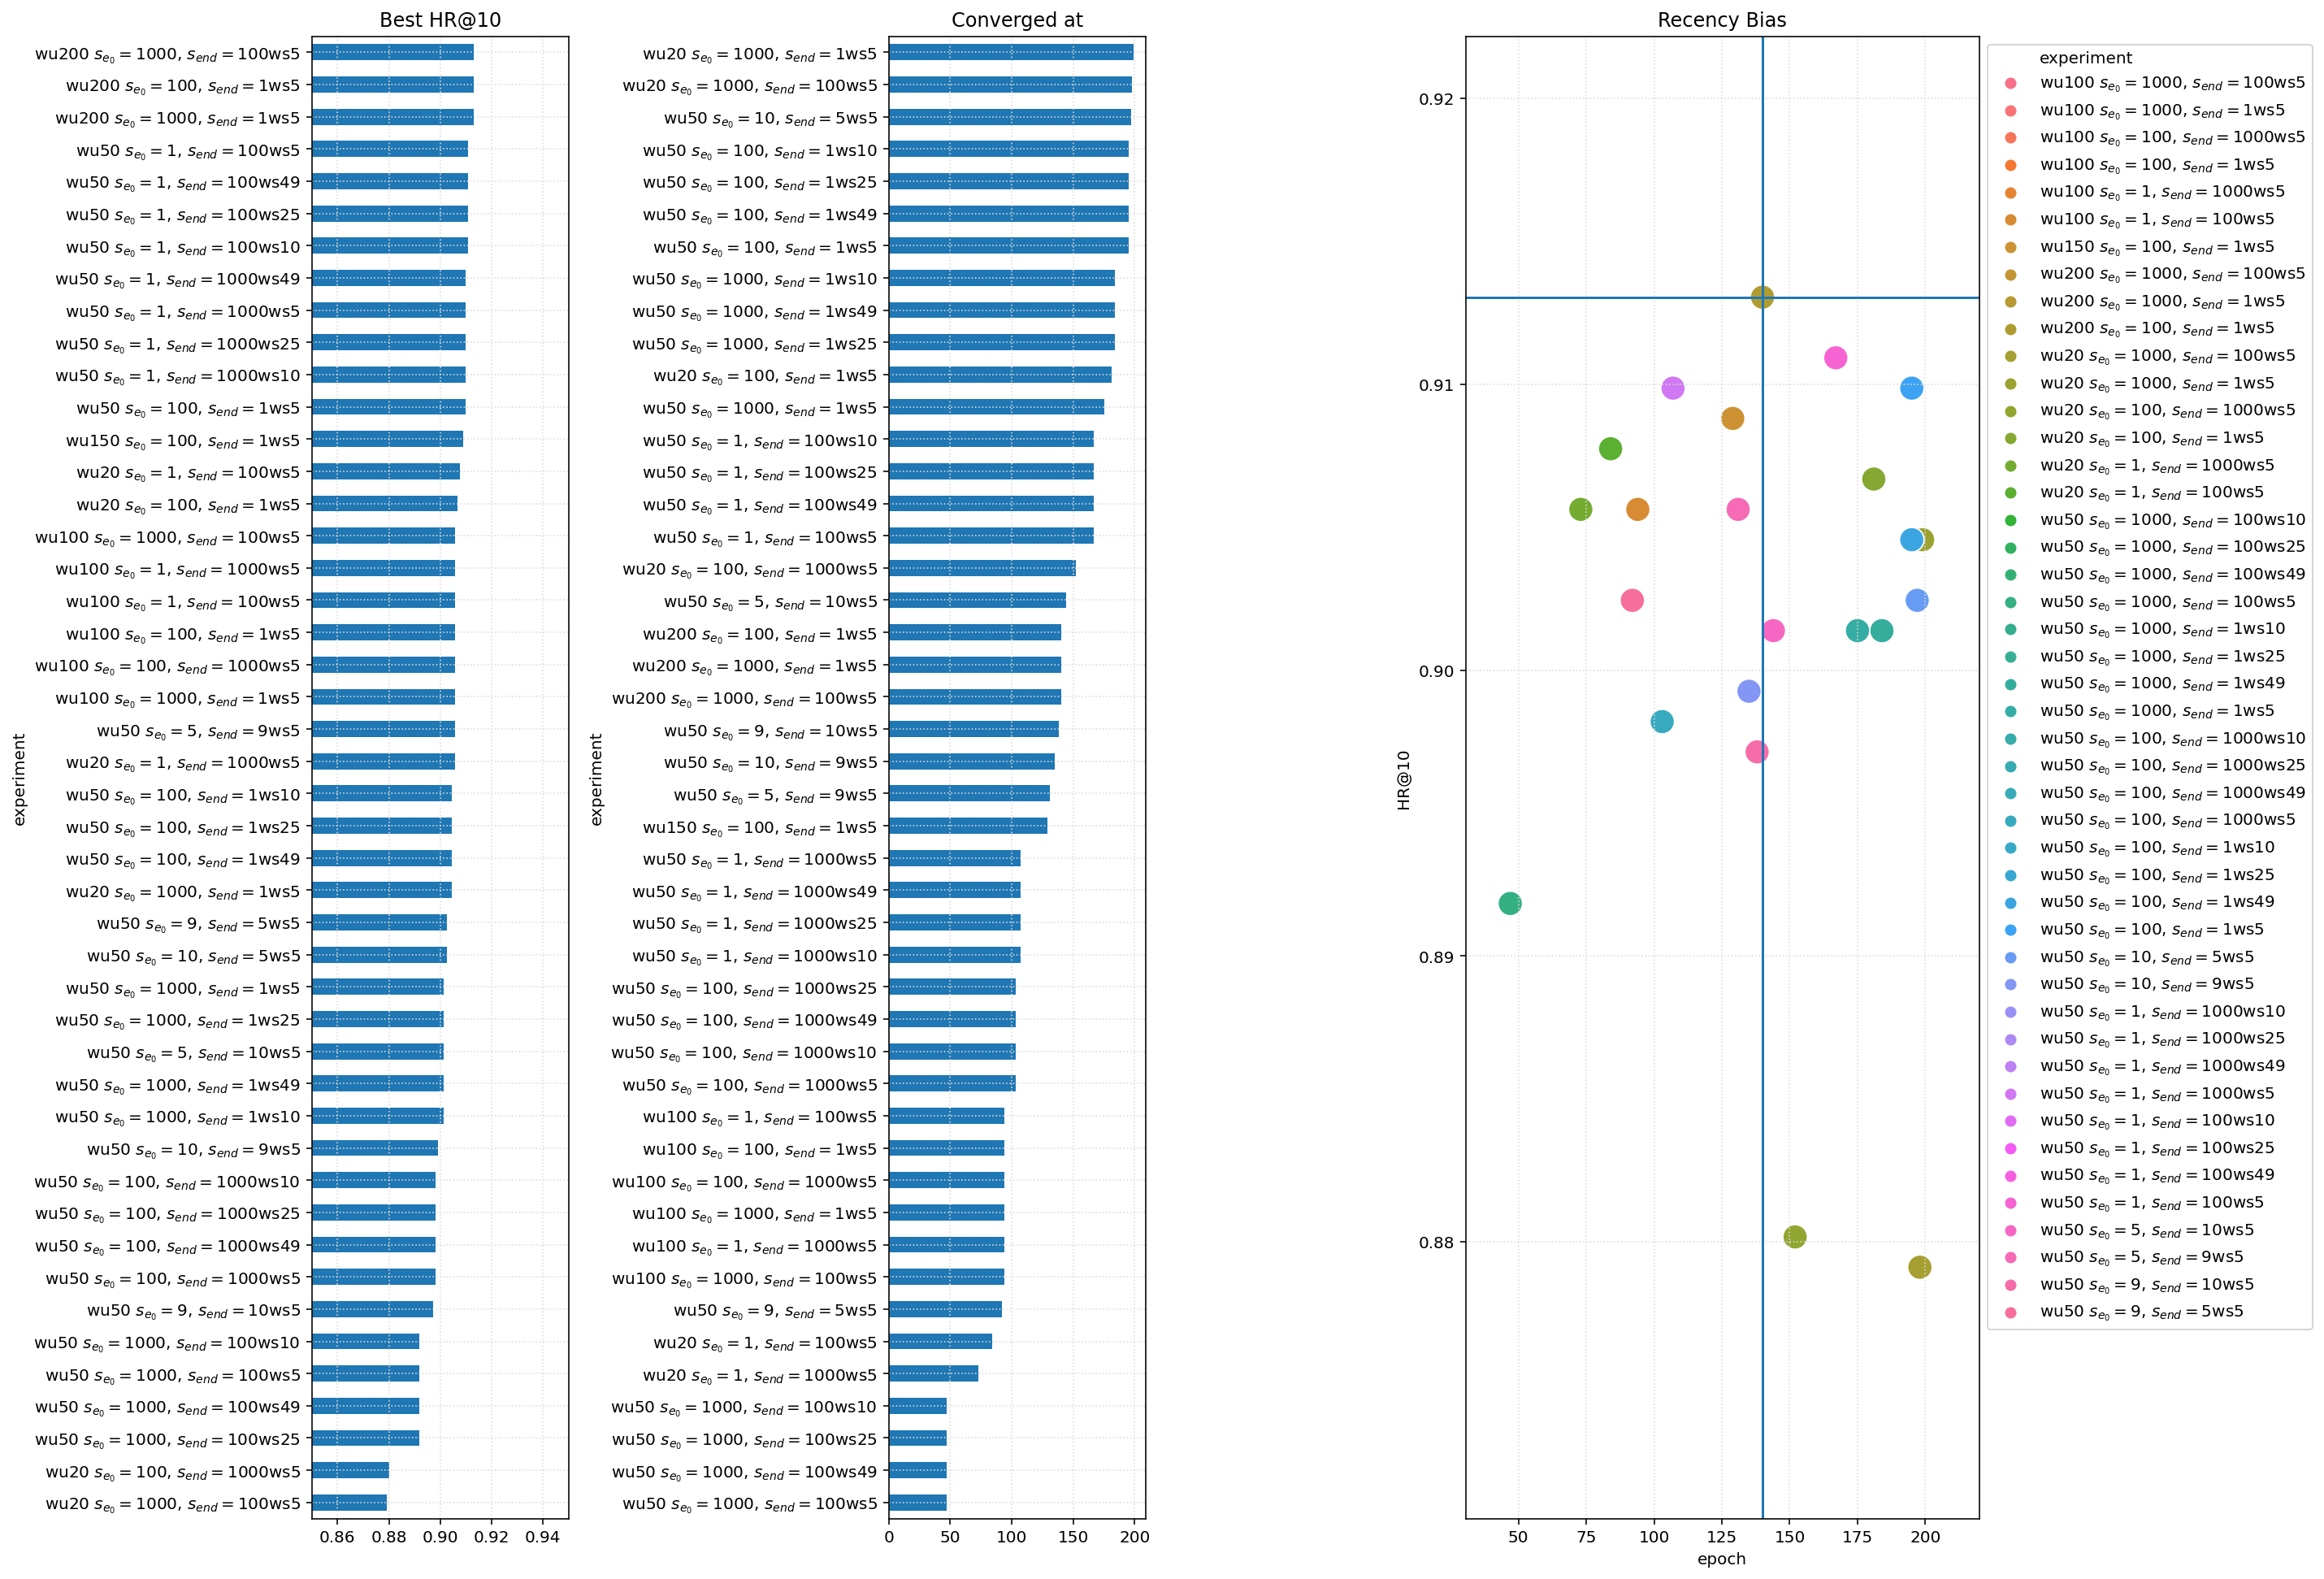

In [131]:
plot_scatter(
    df_best,
    title="Recency Bias",
    criteria=["rec"],
    replacements={
        "ca-": "",
        "-gd-": "",
        "rec": "",
        "se0": " $s_{e_0}=$",
        "send": ", $s_{end}=$",
    },
    figsize=(20, 15)
)

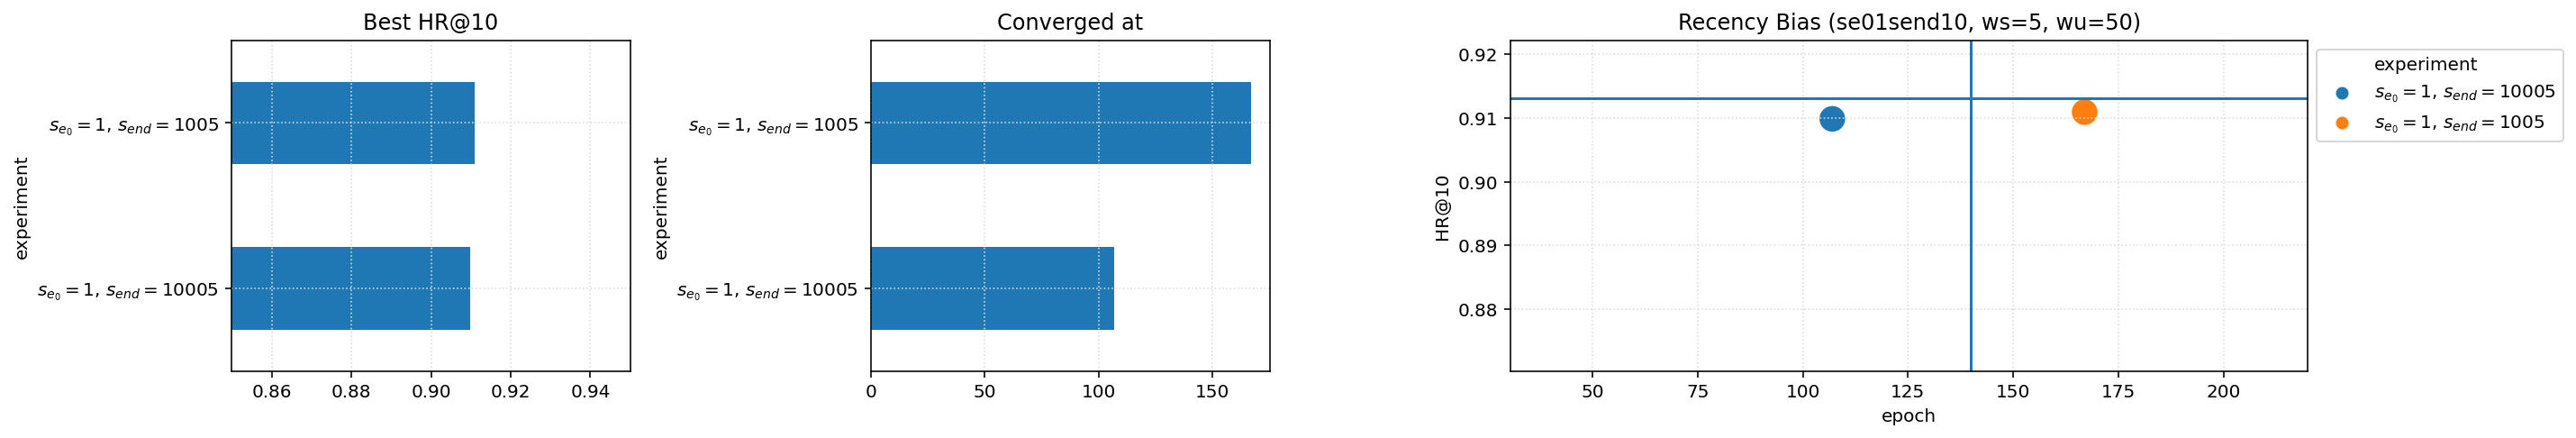

In [113]:
plot_scatter(
    df_best,
    title="Recency Bias (se01send10, ws=5, wu=50)",
    criteria=["rec", "se01send10", "ws5", "wu50"],
    replacements={
        "ca-": "",
        "rec-gd-": "",
        "ws": "",
        "wu50": "",
        "se0": "$s_{e_0}=$",
        "send": ", $s_{end}=$",
    },
    figsize=(20, 3.5),
)

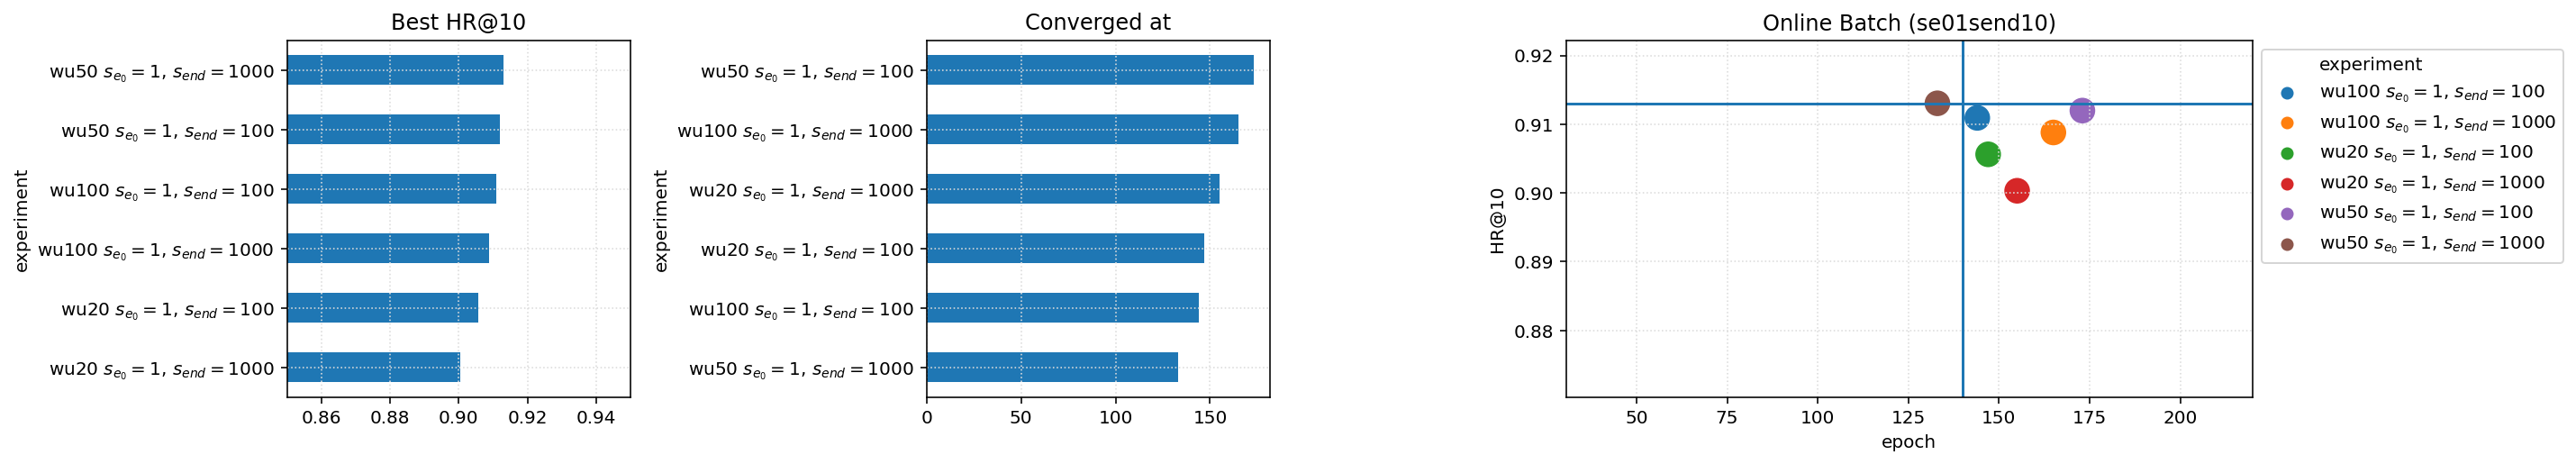

In [142]:
plot_scatter(
    df_best,
    title="Online Batch (se01send10)",
    criteria=["onl", "se01send10"],
    replacements={
        "ca-": "",
        "onl-gd-": "",
        "se0": " $s_{e_0}=$",
        "send": ", $s_{end}=$",
    },
    figsize=(20, 3.7)
)

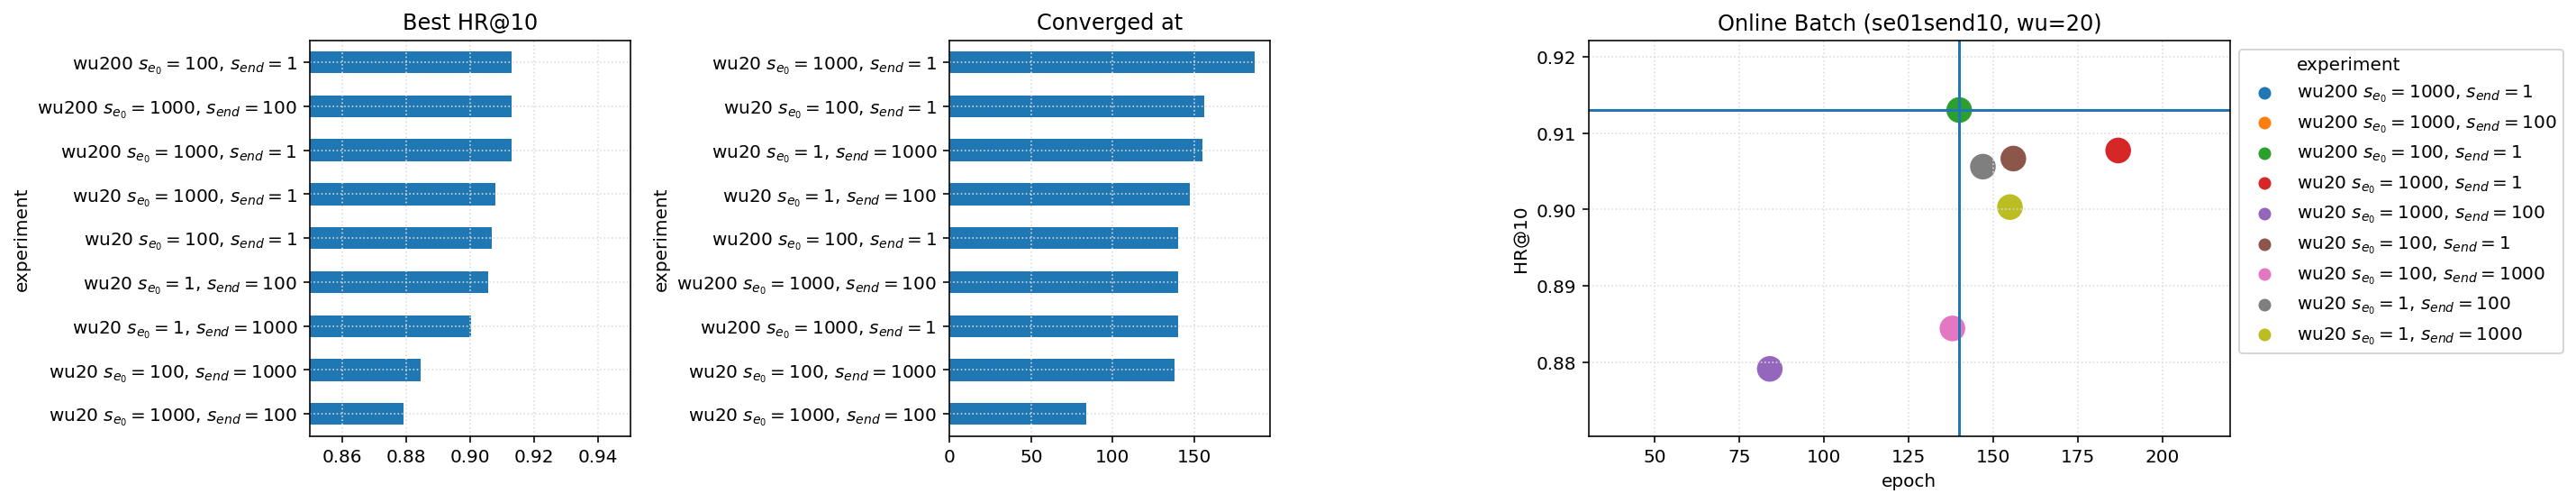

In [143]:
plot_scatter(
    df_best,
    title="Online Batch (se01send10, wu=20)",
    criteria=["onl", "se01", "wu20"],
    replacements={
        "ca-": "",
        "gd-": "",
        "onl-": "",
        "se0": " $s_{e_0}=$",
        "send": ", $s_{end}=$",
    },
    figsize=(20, 4),
)

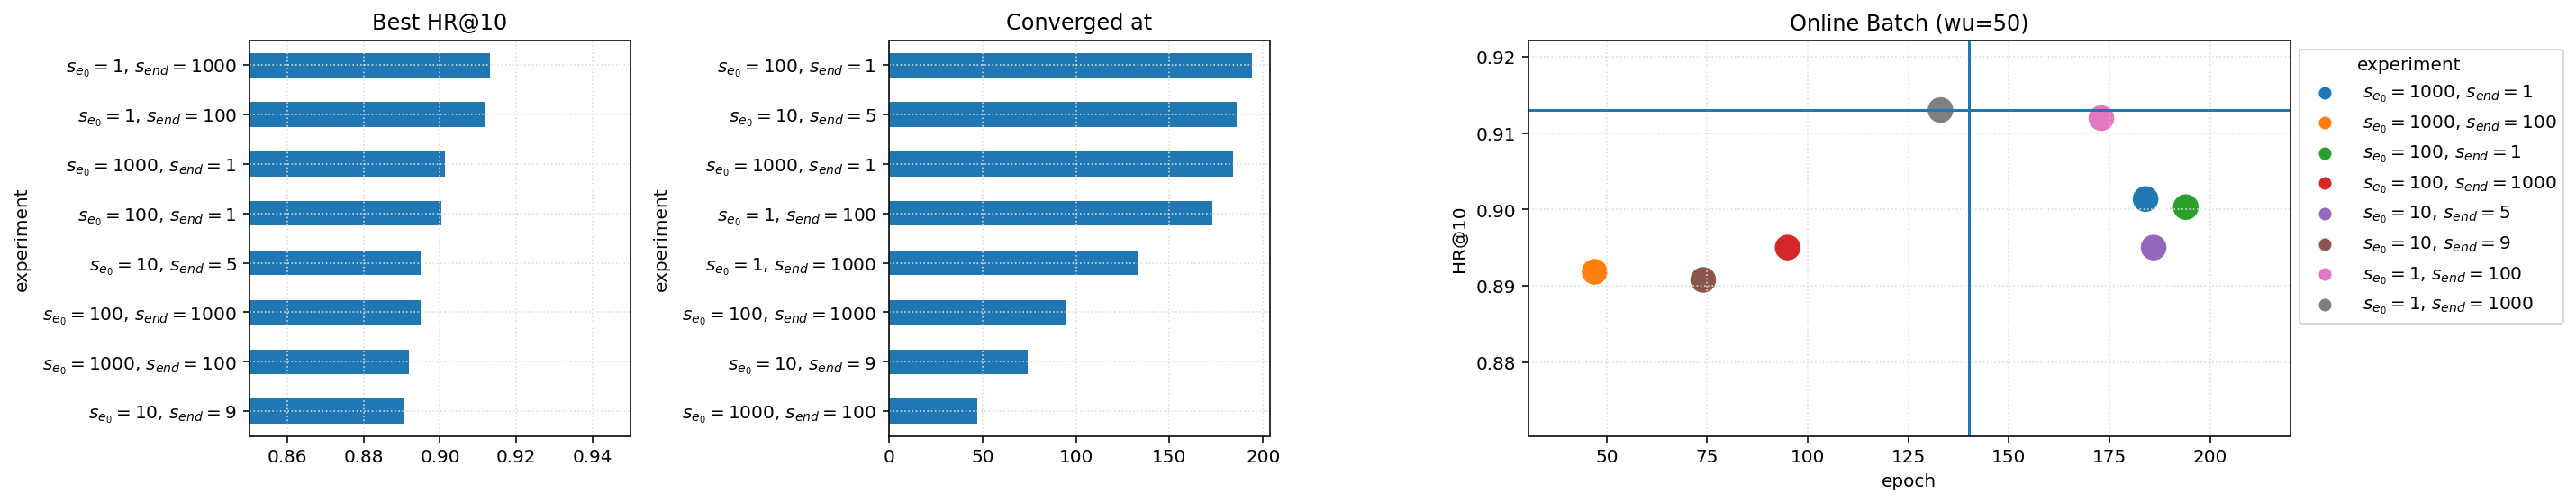

In [138]:
plot_scatter(
    df_best,
    title="Online Batch (wu=50)",
    criteria=["onl", "wu50", "se01"],
    replacements={
        "ca-": "",
        "onl-gd-": "",
        "wu50": "",
        "se0": " $s_{e_0}=$",
        "send": ", $s_{end}=$",
    },
    figsize=(20, 4),
)

In [66]:
# plot_scatter(df_best, title='All', replacements={'-ca-': ''})

In [ ]:
list(list(np.random.randn(5)))

In [ ]:
fig, ax0 = plt.subplots(figsize=(10, 6), nrows=1, sharex=True)
criteria = "experiment in @experiments"
exclude = ["sd", "mk-ran", "se0100send1"]
for label, df in df_all.query(criteria).groupby("experiment"):
    if any(s in label for s in exclude):
        continue

    label_short = (
        label.replace("mk-", "")
        .replace("ca-", "")
        .replace("bs32ep200li005lu005nf10rg001", "")
        .replace("rvT", "")
    )
    df_ = df.set_index("epoch")
    _df_ran = df_all.query('experiment == "mk-ran-bs32ep200li005lu005nf10rg001"')[
        "HR@10"
    ]
    _df = 100 * ((df["HR@10"] - _df_ran) / _df_ran)
    first_max_loc = df_[df_["HR@10"] == df_["HR@10"].max()].index[0]
    #     _df.loc[:first_max_loc].rolling(10).max().plot(ax=ax0, label=label_short, alpha=0.9)
    _df.loc[:first_max_loc].plot(ax=ax0, label=label_short, alpha=0.9, lw=2)
    ax0.axhline(y=_df.max(), xmax=first_max_loc, lw=0.5, ls="dashed")
    #     df.set_index("epoch")["HR@10"].plot(ax=ax0, label=label_short, alpha=0.9)

    #     pd.DataFrame(summaries_dict["RandomSampler"])["HR@10"].plot(
    #         ax=ax0, label="From NB", color="red"
    #     )
    ax0.set_ylabel("HR@10")

#     ax1.set_ylim(0, 1)
#     df.set_index("epoch")["loss_avg"].plot(ax=ax1, label=label_short, alpha=0.9)
#     pd.DataFrame(summaries_dict["RandomSampler"])["loss_avg"].plot(
#         ax=ax1, label="From NB", color="red"
#     )
#     ax1.set_ylabel("Avg Loss")
plt.gca().legend()
fig.tight_layout()
ax0.set_xlim(0, 200)
ax0.grid(color="gainsboro", alpha=0.9, ls=":")
ax0.axhline(y=0, color="black")
# ax1.grid(color='gainsboro', alpha=0.7, ls=":")
plt.title("Percentage gain over RandomSampler's HR@10")
fig.tight_layout()

In [ ]:
Try a different model
Write out algorithm
SD and MN are the same
